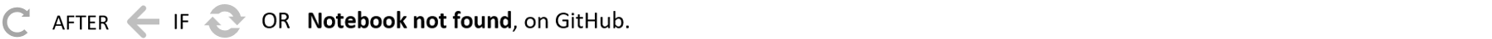

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)

# Wikipedia Notable Life Expectancy

## Notebook 3: Data Cleaning Part 2

### Contents

This notebook covers:
- Extracting `age` Continued:
    - Extracting missing `age` from:
        - `info_2`
    - Extracting "COVID-19" from `info_` columns to `cause_of_death`
    - Checking for remaining digits in other `info_` columns
    - Extracting missing `age` from:
        - `info_parenth`
    - Dropping Additional Entries with Missing `age` (target) Values
- Extracting Nationality Data:
    - Creating Dictionary of Country: Nationality using scraped existing table<sup>1</sup>
    - Inverse Mapping of Dictionary to Nationality: Country
    - Updating Nationality: Country Dictionary with another Existing Nationalities List<sup>2</sup>
- Exporting partially-cleaned dataset to SQLite database
- Saving `nation_country_dict` to a Pickle File


### Instructions
Options for Running this Notebook:
1. Clone the repository:
    - Delete the following files that are generated by this notebook:
        - [wp_life_expect_clean2.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean2.db)
        - [nation_country_dict.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_country_dict.pkl)
    - Navigate to the cloned repository in Jupyter and open the notebook to run it.
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).

2. Save the notebook and database file below to the same working directory:<sup>3</sup>
    - Download the notebook:
        - Click on <kbd>Raw</kbd> above.
        - Save <kbd>Ctrl</kbd> + <kbd>S</kbd>
    - Follow the link to the database, csv, and txt files and click <kbd>Download</kbd>, then move files to the same directory as the notebook:
        - [wp_life_expect_clean1.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean1.db)<sup>4</sup>
        - [nations.csv](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nations.csv)<sup>5</sup>
        - [nationalities.txt](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nationalities.txt)<sup>6</sup>
    - In Jupyter, navigate to the directory in which the notebook and files are saved, to open and run the notebook.  
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).

### Data Dictionary for Loaded Version of Dataset
- **day**:  Day of the month of the individual's death
- **name**:  Name of the individual
- **info**:  Combined Wikipedia-defined fields:
> Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference.<sup>7</sup>
>
- **link**:  Link to an individual's page
- **num_references**:  Number of references for individual's page
- **year**: Year of the individual's death
- **month**: Month of the individual's death
- **info_parenth**: Parentheses and its contents previously in info column
- **info_1** through **info_11**: Resultant remaining columns of split of info column on commas (info_0 already exhausted and dropped)
- **age**: Age of individual at death in years

## Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean1.db), Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean1.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean1", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132843 rows and 20 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,,British dancer,ballet designer and director,None,None,None,None,None,None,None,None,86.0
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,,Irish economist,writer,and academic,None,None,None,None,None,None,None,68.0


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
132841,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,(1980),,Russian volleyball player,Olympic champion and coach,None,None,None,None,None,None,None,None,69.0
132842,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,,Chinese engineer,member of the Chinese Academy of Engineering,None,None,None,None,None,None,None,None,86.0


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
73056,9,Michel Jeury,", 80, French science fiction author.",https://en.wikipedia.org/wiki/Michel_Jeury,1,2015,January,None,,French science fiction author,None,None,None,None,None,None,None,None,None,80.0
49073,7,Blažena Holišová,", 80, Czech film and theatre actress.",https://en.wikipedia.org/wiki/Bla%C5%BEena_Holi%C5%A1ov%C3%A1,2,2011,April,None,,Czech film and theatre actress,None,None,None,None,None,None,None,None,None,80.0
34721,26,Takafumi Isomura,", 76, Japanese politician, mayor of Osaka , hepatocellular carcinoma.",https://en.wikipedia.org/wiki/Takafumi_Isomura,1,2007,November,(1995–2003),,Japanese politician,mayor of Osaka,hepatocellular carcinoma,None,None,None,None,None,None,None,76.0
41036,6,Robert McNamara,", 93, American business executive, Secretary of Defense , natural causes.",https://en.wikipedia.org/wiki/Robert_McNamara,213,2009,July,(1961–1968),,American business executive,Secretary of Defense,natural causes,None,None,None,None,None,None,None,93.0
2765,23,Peter Wykeham,", 79, Royal Air Force Air marshal and flying ace during World War II.",https://en.wikipedia.org/wiki/Peter_Wykeham,3,1995,February,None,,Royal Air Force Air marshal and flying ace during World War II,None,None,None,None,None,None,None,None,None,79.0


<IPython.core.display.Javascript object>

#### Observations:
- There are currently 132,843 rows and 20 columns.

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132843 entries, 0 to 132842
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   day             132843 non-null  object 
 1   name            132843 non-null  object 
 2   info            132843 non-null  object 
 3   link            132843 non-null  object 
 4   num_references  132843 non-null  object 
 5   year            132843 non-null  int64  
 6   month           132843 non-null  object 
 7   info_parenth    50002 non-null   object 
 8   info_1          132843 non-null  object 
 9   info_2          132814 non-null  object 
 10  info_3          62861 non-null   object 
 11  info_4          12648 non-null   object 
 12  info_5          1503 non-null    object 
 13  info_6          218 non-null     object 
 14  info_7          33 non-null      object 
 15  info_8          7 non-null       object 
 16  info_9          1 non-null       object 
 17  info_10   

<IPython.core.display.Javascript object>

#### Observations:
- Our dataset was saved to and read from the database without any hiccups.
- We will typecast object columns later, after value extraction, if needed.
- Picking up where we left off, we will aim to track down the remaining missing values for `age`, starting with searching for digits in `info_2`.

## Extracting `age` Continued

### Remaining Missing Values for `age`

In [6]:
# Checking number of remaining missing values
print(f'There are {df["age"].isna().sum()} missing values for age.')

There are 218 missing values for age.


<IPython.core.display.Javascript object>

#### Function to Save Indices of Rows Matching Regular Expressions Pattern to a List and Print Number of Rows with Match

In [7]:
# Define a function that takes dataframe, column name, and re pattern as arguments and returns list of indices
# for which column value matches re pattern
def rows_with_pattern(dataframe, column, pattern):
    """
    Takes input of dataframe, column name, and re pattern 
    and returns list of indices for rows that contain match
    for pattern anywhere within value for given column.
    
    dataframe: dataframe
    column: column name
    pattern: re pattern
    """
    index_list = []

    for i in dataframe.index:
        item = dataframe.loc[i, column]
        match = re.search(pattern, item)
        if match:
            index_list.append(i)
    print(
        f"There are {len(index_list)} rows with matching pattern in column '{column}'."
    )
    return index_list

<IPython.core.display.Javascript object>

#### Function to Use `rows_with_pattern` Function for Multiple Regular Expression Patterns

In [8]:
# Define a function that calls rows_with_pattern function for multiple re patterns
# returning a single list of indices for all rows with any pattern match


def multiple_patterns(dataframe, column, patterns):
    """
    Takes input dataframe, column, and list of re patterns and returns single list 
    of indices for rows in which a match for any pattern is found with re.search
    
    dataframe: dataframe
    column: column name
    patterns: list of re patterns
    """
    rows_combined = []

    # For loop to check each pattern
    for pattern in patterns:

        # List and number of rows matching each pattern
        print(pattern)
        rows_to_check = rows_with_pattern(dataframe, column, pattern)
        print("")

        # Add list for each pattern to combined list
        rows_combined += rows_to_check

    return rows_combined

<IPython.core.display.Javascript object>

### `info_2`

#### Rows Missing `age` with Digits in `info_2`

In [9]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Pattern for re
pattern = r"\d"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Examining the rows directly
df.loc[rows_to_check, :]

There are 47 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
6832,17,Spiro Agnew,", American politician, 77, 39th Vice President of the United States, leukemia.",https://en.wikipedia.org/wiki/Spiro_Agnew,207,1996,September,None,American politician,77,39th Vice President of the United States,leukemia,None,None,None,None,None,None,None,NaN
12826,14,Muslimgauze,", , 37, British electronic musician, fungal infection.",https://en.wikipedia.org/wiki/Muslimgauze,26,1999,January,(Bryn Jones),,37,British electronic musician,fungal infection,None,None,None,None,None,None,None,NaN
14954,15,Željko Ražnatović,", , 47, Serbian mobster and paramilitary leader.",https://en.wikipedia.org/wiki/Arkan,55,2000,January,(aka Arkan),,47,Serbian mobster and paramilitary leader,None,None,None,None,None,None,None,None,NaN
15023,28,Sarah Caudwell,", , 60, British detective story writer and barrister, cancer.",https://en.wikipedia.org/wiki/Sarah_Caudwell,9,2000,January,(aka Sarah Cockburn),,60,British detective story writer and barrister,cancer,None,None,None,None,None,None,None,NaN
16069,30,Max Showalter,", , 83, American actor, composer, pianist, singer, cancer.",https://en.wikipedia.org/wiki/Max_Showalter,14,2000,July,(aka Casey Adams),,83,American actor,composer,pianist,singer,cancer,None,None,None,None,NaN
17745,15,Joey Ramone,", , 49, American musician, lead singer for The Ramones, lymphoma.",https://en.wikipedia.org/wiki/Joey_Ramone,25,2001,April,(b. Jeffrey Hyman),,49,American musician,lead singer for The Ramones,lymphoma,None,None,None,None,None,None,NaN
18120,4,Dipendra,", King of Nepal, 29, suicide.",https://en.wikipedia.org/wiki/Dipendra_of_Nepal,8,2001,June,None,King of Nepal,29,suicide,None,None,None,None,None,None,None,None,NaN
18963,28,Mohammad Khalequzzaman,", member of the then National Assembly of Pakistan and Union Minister of Labor, died in 28 September 2001.",https://en.wikipedia.org/wiki/Mohammad_Khalequzzaman,3,2001,September,None,member of the then National Assembly of Pakistan and Union Minister of Labor,died in 28 September 2001,None,None,None,None,None,None,None,None,None,NaN
19063,12,Lord Hailsham of St Marylebone,", , 94, British lawyer and politician.","https://en.wikipedia.org/wiki/Quintin_Hogg,_Baron_Hailsham_of_St_Marylebone",17,2001,October,(Quintin Hogg),,94,British lawyer and politician,None,None,None,None,None,None,None,None,NaN
23688,6,Jules Engel,", Jules Engel, 94, American filmmaker, visual artist, and film director.",https://en.wikipedia.org/wiki/Jules_Engel,10,2003,September,None,Jules Engel,94,American filmmaker,visual artist,and film director,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

#### Observations:
- There are several ages as sole integer year values and 2 values as year ranges with two integers.
- The remaining entries are missing age, but do have digits, so order of processing matters here.
- We can safely remove any of these rows that contains a letter of the alphabet, taking care to select rows only from those that are missing `age` and have a digit in `info_2`.

In [10]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df.loc[rows_to_check, :]

# Pattern for re
pattern = r"[a-z,A-Z]"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking a sample of the rows
df.loc[rows_to_check, :].sample(2)

There are 21 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
110953,14,Danny Delaney,", Irish Gaelic footballer , COVID-19.",https://en.wikipedia.org/wiki/Danny_Delaney,6,2020,April,"(Laois, Stradbally)",Irish Gaelic footballer,COVID-19,None,None,None,None,None,None,None,None,None,NaN
122705,20,U. Visweswar Rao,", Indian film director and screenwriter, COVID-19.",https://en.wikipedia.org/wiki/U._Visweswar_Rao,9,2021,May,"(, )",Indian film director and screenwriter,COVID-19,None,None,None,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

#### Observations:
- We can drop these rows, as they are missing the data for age.
- Extraction of age for two integer ranges, then single integer values, can follow.

#### Dropping Additional Rows with Age Data Absent

In [11]:
# Dropping rows, resetting index, and checking new shape of df
rows_to_drop = rows_to_check.copy()
df.drop(rows_to_drop, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132822, 20)

<IPython.core.display.Javascript object>

#### Remaining Rows with `age` Values in `info_2`

In [12]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Regular expression for parenthesis and its contents
pattern = r"\d"

# Finding indices of rows that have pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking unique values
df.loc[rows_to_check, :]["info_2"].unique()

There are 26 rows with matching pattern in column 'info_2'.


array(['77', '37', '47', '60', '83', '49', '29', '94', '55', '62', '69',
       '80', '32', '70', '81', '24', '84', '95', '76', '86', '61',
       '74–75', '79–80'], dtype=object)

<IPython.core.display.Javascript object>

#### Extracting `age` for Ranges with Two Values

In [13]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Pattern for re
pattern = r"(\d{1,3})(-|–)(\d{1,3})"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking sample of rows
df.loc[rows_to_check, :].sample(2)

There are 2 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
61963,1,Basil Soper,", British actor, 74–75.",https://en.wikipedia.org/wiki/Basil_Soper,0,2013,June,None,British actor,74–75,None,None,None,None,None,None,None,None,None,NaN
87097,8,Mohamud Muse Hersi,", Somali politician, 79–80, President of Puntland .",https://en.wikipedia.org/wiki/Mohamud_Muse_Hersi,12,2017,February,(2005–2009),Somali politician,79–80,President of Puntland,None,None,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

In [14]:
# For loop to find rows with values and pattern and calculate and extract age to age column and remove age from info_2
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = (int(match.group(1)) + int(match.group(3))) / 2
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Rechecking number of rows after treatment
recheck_rows = rows_with_pattern(df.loc[rows_to_check, :], column, pattern)

# Recheck a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
87097,8,Mohamud Muse Hersi,", Somali politician, 79–80, President of Puntland .",https://en.wikipedia.org/wiki/Mohamud_Muse_Hersi,12,2017,February,(2005–2009),Somali politician,,President of Puntland,None,None,None,None,None,None,None,None,79.5
61963,1,Basil Soper,", British actor, 74–75.",https://en.wikipedia.org/wiki/Basil_Soper,0,2013,June,None,British actor,,None,None,None,None,None,None,None,None,None,74.5


<IPython.core.display.Javascript object>

#### Extracting `age` as Single Integer

In [15]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# List of patterns for age formats with single integer for age
pattern = r"\b(\d{1,3})\b"

# Rechecking number of rows after treatment
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking sample of rows
df.loc[rows_to_check, :].sample(2)

There are 24 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
24814,8,Muhammad Zaidan,", , 55, Palestinian nationalist, founder of Palestine Liberation Front.",https://en.wikipedia.org/wiki/Muhammad_Zaidan,4,2004,March,(aka Abu Abbas),,55,Palestinian nationalist,founder of Palestine Liberation Front,None,None,None,None,None,None,None,NaN
15023,28,Sarah Caudwell,", , 60, British detective story writer and barrister, cancer.",https://en.wikipedia.org/wiki/Sarah_Caudwell,9,2000,January,(aka Sarah Cockburn),,60,British detective story writer and barrister,cancer,None,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

In [16]:
# For loop to extract age pattern to age column
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = int(match.group(1))
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Re-checking number of rows matching pattern
recheck_rows = rows_with_pattern(df.loc[rows_to_check, :], column, pattern)

# Recheck a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_2'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
14954,15,Željko Ražnatović,", , 47, Serbian mobster and paramilitary leader.",https://en.wikipedia.org/wiki/Arkan,55,2000,January,(aka Arkan),,,Serbian mobster and paramilitary leader,None,None,None,None,None,None,None,None,47.0
28301,28,Esther Szekeres,", , 95, Hungarian mathematician.",https://en.wikipedia.org/wiki/Esther_Szekeres,5,2005,August,(née Klein),,,Hungarian mathematician,None,None,None,None,None,None,None,None,95.0


<IPython.core.display.Javascript object>

#### Verifying No Remaining Digits `info_2`

In [17]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Regular expression for parenthesis and its contents
pattern = r"\d"

# Finding indices of rows that have pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

There are 0 rows with matching pattern in column 'info_2'.


<IPython.core.display.Javascript object>

#### Number of Remaining Missing Values

In [18]:
# Checking number of remaining missing values
print(f'There are {df["age"].isna().sum()} missing values for age.')
df[df["age"].isna()].sample(2)

There are 171 missing values for age.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
97302,22,Ikramullah Gandapur,", Pakistani politician, Khyber Pakhtunkhwa Minister for Agriculture , bombing.",https://en.wikipedia.org/wiki/Ikramullah_Gandapur,9,2018,July,(2014–2018),Pakistani politician,Khyber Pakhtunkhwa Minister for Agriculture,bombing,None,None,None,None,None,None,None,None,NaN
104995,5,Rashiram Debbarma,", Indian politician, MLA .",https://en.wikipedia.org/wiki/Rashiram_Debbarma,5,2019,August,(1977–1998),Indian politician,MLA,None,None,None,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

#### Observations:
- We have narrowed the missing values for `age` down to 171.
- `info_parenth`, and `info_3` and above are the remaining columns to search.
- We see that "COVID-19" appears often and the number 19 could be mistakenly extracted as an age.  
- Let us start by moving it to a new column, `cause_of_death`, for the entries with missing `age`.

#### Extracting "COVID-19" from Remaining `info_` Columns for Rows with Missing `age` Value

In [19]:
# List of columns to check
cols_to_check = [
    "info_parenth",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Dataframe to check
dataframe = df[df["age"].isna()]

# Pattern for re
pattern = r"(COVID-19)"

# For loop to collect indices of all rows with pattern
comb_rows_to_check = []
for column in cols_to_check:
    rows_to_check = rows_with_pattern(
        dataframe[dataframe[column].notna()], column, pattern
    )
    comb_rows_to_check += rows_to_check

# Checking sample of rows
df.loc[comb_rows_to_check, :].sample(2)

There are 1 rows with matching pattern in column 'info_parenth'.
There are 30 rows with matching pattern in column 'info_3'.
There are 2 rows with matching pattern in column 'info_4'.
There are 1 rows with matching pattern in column 'info_5'.
There are 0 rows with matching pattern in column 'info_6'.
There are 0 rows with matching pattern in column 'info_7'.
There are 0 rows with matching pattern in column 'info_8'.
There are 0 rows with matching pattern in column 'info_9'.
There are 0 rows with matching pattern in column 'info_10'.
There are 0 rows with matching pattern in column 'info_11'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
118468,14,Dinesh Chandra Yadav,", Nepalese politician, member of the Constituent Assembly , COVID-19.",https://en.wikipedia.org/wiki/Dinesh_Chandra_Yadav_(Nepali_politician),4,2021,January,(2014–2017),Nepalese politician,member of the Constituent Assembly,COVID-19,None,None,None,None,None,None,None,None,NaN
122152,3,Hamid Rashid Ma`ala,", Iraqi politician, MP , COVID-19.",https://en.wikipedia.org/wiki/Hamid_Rashid_Ma%60ala,2,2021,May,(2005–2010),Iraqi politician,MP,COVID-19,None,None,None,None,None,None,None,None,NaN


<IPython.core.display.Javascript object>

In [20]:
# For loop to extract COVID-19 from remaining info_ columns for entries with missing age
for column in cols_to_check:
    for index in comb_rows_to_check:
        if df.loc[index, column]:
            item = df.loc[index, column]
            match = re.search(pattern, item)
            if match:
                cause = match.group(1)
                df.loc[index, "cause_of_death"] = cause
                df.loc[index, column] = re.sub(
                    pattern, "", df.loc[index, column]
                ).strip()

# For loop to collect indices of all rows with pattern
for column in cols_to_check:
    rows_to_check = rows_with_pattern(
        df.loc[comb_rows_to_check, :][df[column].notna()], column, pattern
    )

# Recheck a sample of treated rows
df.loc[comb_rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_parenth'.
There are 0 rows with matching pattern in column 'info_3'.
There are 0 rows with matching pattern in column 'info_4'.
There are 0 rows with matching pattern in column 'info_5'.
There are 0 rows with matching pattern in column 'info_6'.
There are 0 rows with matching pattern in column 'info_7'.
There are 0 rows with matching pattern in column 'info_8'.
There are 0 rows with matching pattern in column 'info_9'.
There are 0 rows with matching pattern in column 'info_10'.
There are 0 rows with matching pattern in column 'info_11'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
117493,18,Robina Sentongo,", Ugandan politician, MP , COVID-19.",https://en.wikipedia.org/wiki/Robina_Sentongo,2,2020,December,(since 2016),Ugandan politician,MP,,None,None,None,None,None,None,None,None,NaN,COVID-19
110789,10,Ceybil Jefferies,", American house and R&B singer",https://en.wikipedia.org/wiki/Ceybil_Jefferies,4,2020,April,"(""It's Gonna Be Alright""), . (death announced on this day)",American house and R&B singer,None,None,None,None,None,None,None,None,None,None,NaN,COVID-19


<IPython.core.display.Javascript object>

#### Observations:
- With "COVID-19" put aside, we can check for any remaining digits in the same columns for these entries.
- The new column `cause_of_death` has been added.

#### Checking Remaining `info_` Columns for Remaining Digits

In [21]:
# List of columns to check
cols_to_check = [
    "info_parenth",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Dataframe to check
dataframe = df[df["age"].isna()]

# Pattern for re
pattern = r"\d"

# For loop to collect indices of all rows with pattern
comb_rows_to_check = []
for column in cols_to_check:
    rows_to_check = rows_with_pattern(
        dataframe[dataframe[column].notna()], column, pattern
    )
    comb_rows_to_check += rows_to_check

# Checking sample of rows
df.loc[comb_rows_to_check, :].sample(5)

There are 162 rows with matching pattern in column 'info_parenth'.
There are 0 rows with matching pattern in column 'info_3'.
There are 0 rows with matching pattern in column 'info_4'.
There are 0 rows with matching pattern in column 'info_5'.
There are 0 rows with matching pattern in column 'info_6'.
There are 0 rows with matching pattern in column 'info_7'.
There are 0 rows with matching pattern in column 'info_8'.
There are 0 rows with matching pattern in column 'info_9'.
There are 0 rows with matching pattern in column 'info_10'.
There are 0 rows with matching pattern in column 'info_11'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
104361,5,Mohan Das,", Indian politician, MLA .",https://en.wikipedia.org/wiki/Mohan_Das_(politician),2,2019,July,(1996–2001),Indian politician,MLA,None,None,None,None,None,None,None,None,None,NaN,NaN
68353,9,Flossie Gomile-Chidyaonga,", Malawian diplomat involved in leaked diplomatic cable controversy, High Commissioner to Tanzania .",https://en.wikipedia.org/wiki/Flossie_Gomile-Chidyaonga,9,2014,May,(since 2011),Malawian diplomat involved in leaked diplomatic cable controversy,High Commissioner to Tanzania,None,None,None,None,None,None,None,None,None,NaN,NaN
126481,8,Peter Gill,", Pakistani politician, Punjab MPA .",https://en.wikipedia.org/wiki/Peter_Gill_(politician),2,2021,October,(since 2018),Pakistani politician,Punjab MPA,None,None,None,None,None,None,None,None,None,NaN,NaN
126968,27,Gerald R. Young,", American intelligence official, deputy director of the National Security Agency .",https://en.wikipedia.org/wiki/Gerald_R._Young,6,2021,October,(1988–1990),American intelligence official,deputy director of the National Security Agency,None,None,None,None,None,None,None,None,None,NaN,NaN
118812,23,Makhosi Vilakati,", Swazi politician, minister of labour and social security , COVID-19.",https://en.wikipedia.org/wiki/Makhosi_Vilakati,2,2021,January,(since 2019),Swazi politician,minister of labour and social security,,None,None,None,None,None,None,None,None,NaN,COVID-19


<IPython.core.display.Javascript object>

#### Observations:
- `info_parenth` is the only column that still contains digits for rows with missing `age`.
- Let us check its unique values that contain digits.

In [22]:
# Column to check
column = "info_parenth"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Pattern for re
pattern = r"\d"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking unique values
df.loc[rows_to_check, :]["info_parenth"].unique()

There are 162 rows with matching pattern in column 'info_parenth'.


array(['(1993 – 1994)',
       '(née Eva Narcissus Boyd), 59, American pop singer ()',
       '(1994, 2004) and foreign minister (1995–1996)', '(1981–1983)',
       '(1962–1963)', '(2006–2007)', '(1975)', '(1997–1999)', '(2003)',
       '(2006–2008)', '(since 2010)', '(since 2011)', '(2012)',
       '(national team, 1982–1986)', '(2008–2012)', '(since 2001)',
       '(2013)', '(1993–1998)', '(1988–1991)', '(1967–1969, 1969–1974)',
       '(2010–2013)', '(1999–2005)',
       '(2001–2005), Interior Minister (2007–2008)',
       '(2001–2002), MP for Karachuonyo (1997–2007)', '(1993–1997)',
       '(1995)', '(2004–2005)', '(1998)', '(1999)', '(since 2012)',
       '(since 2008)', '(2015)', '(since 2015)', '(since 2013)', '(2008)',
       '(2004)', '(1989)',
       '(since 2016), Governor of Basilan (2007–2016)',
       '(since 2010). (death announced on this date)', '(2007–2013)',
       '(2002)', '(2006)', '(2003–2007)', '(since 2006)', '(2005–2013)',
       '(1998–1999)', '(1988)', '(201

<IPython.core.display.Javascript object>

#### Observations:
- There is one age and one other digit value that is not a year.
- The remainder are 4-digit year values, except for one row that contains "2fm".
- Let us examine the row with `info_parenth` value "(RTÉ 2fm)".

In [23]:
# Checking row containing 2fm
df[df["info_parenth"] == "(RTÉ 2fm)"]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
127074,31,Simon Young,", Irish radio presenter .",https://en.wikipedia.org/wiki/Simon_Young_(presenter),9,2021,October,(RTÉ 2fm),Irish radio presenter,None,None,None,None,None,None,None,None,None,None,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- The value in `info_parenth` for the above row is consistent with a radio station identification.  There is no age data for the row.
- We can proceed to extract the one remaining age value from `info_parenth`, then drop the remaining rows as they are missing age data.

#### Extracting `age` from `info_parenth`

In [24]:
# Column to check
column = "info_parenth"

# Dataframe to check
dataframe = df[(df["age"].isna()) & (df[column].notna())]

# Pattern for re
pattern = r"\b(\d{1,3})\b"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking row
df.loc[rows_to_check, :]

There are 1 rows with matching pattern in column 'info_parenth'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
22792,10,Little Eva,", .",https://en.wikipedia.org/wiki/Little_Eva,14,2003,April,"(née Eva Narcissus Boyd), 59, American pop singer ()",,None,None,None,None,None,None,None,None,None,None,NaN,NaN


<IPython.core.display.Javascript object>

In [25]:
# For loop to extract age pattern to age column
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = int(match.group(1))
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Re-checking number of rows matching pattern
recheck_rows = rows_with_pattern(
    df.loc[rows_to_check, :][df[column].notna()], column, pattern
)

# Rechecking treated row
df.loc[rows_to_check, :]

There are 0 rows with matching pattern in column 'info_parenth'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
22792,10,Little Eva,", .",https://en.wikipedia.org/wiki/Little_Eva,14,2003,April,"(née Eva Narcissus Boyd), , American pop singer ()",,None,None,None,None,None,None,None,None,None,None,59.0,NaN


<IPython.core.display.Javascript object>

#### Observations:
- All of the age data has been captured and it's time to drop the remaining entries with missing values for `age`.

#### Dropping the Last Entries with Missing `age` Values

In [26]:
# Checking number of remaining missing values
print(f'There are {df["age"].isna().sum()} missing values for age.')

There are 170 missing values for age.


<IPython.core.display.Javascript object>

In [27]:
# Dropping rows, resetting index, and checking new shape of df
df.dropna(subset="age", inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132652, 21)

<IPython.core.display.Javascript object>

In [28]:
# Checking current info status
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   day             132652 non-null  object 
 1   name            132652 non-null  object 
 2   info            132652 non-null  object 
 3   link            132652 non-null  object 
 4   num_references  132652 non-null  object 
 5   year            132652 non-null  int64  
 6   month           132652 non-null  object 
 7   info_parenth    49830 non-null   object 
 8   info_1          132652 non-null  object 
 9   info_2          132630 non-null  object 
 10  info_3          62778 non-null   object 
 11  info_4          12645 non-null   object 
 12  info_5          1502 non-null    object 
 13  info_6          218 non-null     object 
 14  info_7          33 non-null      object 
 15  info_8          7 non-null       object 
 16  info_9          1 non-null       object 
 17  info_10   

<IPython.core.display.Javascript object>

#### Observations:
- We have 132,652  entries containing the target variable `age`.
- Some of these rows represent members of non-human species, and may represent groups, as we have observed previously.
- Note that all of the entries for which we hard-coded "COVID-19" as `cause_of_death` were dropped, so there are no remaining values in `cause_of_death`.
- We have been replacing values extracted with empty strings.  Before moving forward let us replace these empty strings with Nan, as it will simplify slicing the dataframe.
- Then it will be time to search for nationality.

#### Replacing Empty Strings with NaN

In [29]:
# Replacing empty strings with NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

<IPython.core.display.Javascript object>

In [30]:
# Checking the NaN values per column
df.isna().sum()

day                    0
name                   0
info                   0
link                   0
num_references         0
year                   0
month                  0
info_parenth       82822
info_1            132617
info_2                48
info_3             70081
info_4            120047
info_5            131155
info_6            132436
info_7            132621
info_8            132646
info_9            132651
info_10           132651
info_11           132651
age                    0
cause_of_death    132652
dtype: int64

<IPython.core.display.Javascript object>

## Extracting Nationality Data

In [31]:
# Checking a sample
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
12228,7,Ronnie Ford,", 84, English cricket player and Royal Air Force officer.",https://en.wikipedia.org/wiki/Ronnie_Ford,11,1998,October,None,NaN,English cricket player and Royal Air Force officer,None,None,None,None,None,None,None,None,None,84.0,NaN
120159,6,Pedro Novoa,", 46, Peruvian writer and educator, colon cancer.",https://en.wikipedia.org/wiki/Pedro_Novoa,2,2021,March,None,NaN,Peruvian writer and educator,colon cancer,None,None,None,None,None,None,None,None,46.0,NaN
64489,27,Fred Creba,", 68, New Zealand Paralympic sportsperson.",https://en.wikipedia.org/wiki/Fred_Creba,2,2013,October,None,NaN,New Zealand Paralympic sportsperson,None,None,None,None,None,None,None,None,None,68.0,NaN
45584,1,Geoffrey Hutchings,", 71, English actor , viral infection.",https://en.wikipedia.org/wiki/Geoffrey_Hutchings,3,2010,July,"(, , )",NaN,English actor,viral infection,None,None,None,None,None,None,None,None,71.0,NaN
5669,9,Mohammed al-Ghazali,", 78, Egyptian Islamic cleric and scholar.",https://en.wikipedia.org/wiki/Mohammed_al-Ghazali,10,1996,March,None,NaN,Egyptian Islamic cleric and scholar,None,None,None,None,None,None,None,None,None,78.0,NaN


<IPython.core.display.Javascript object>

#### Observations:
- `info_2` appears overall consistent with the Wikipedia field  that combines "citizenship" and "known for".
- The first word does appear to represent the nationality, typically.
- Recall that this information is in `info_1` for some entries and may also be in other `info_` columns beyond `info_2`.
- Running the sample check a few times reveals that when there are there two citizenships (first and second), they may be in the formats of "nationality1-born nationality2", "nationality1-nationality2", or "nationality1 nationality2".
- There are nationalities that have multiple words and there are also additional capitalized words that are not part of the nationality.

### Dictionary of Country: Nationality Values
- It would be helpful to have a comprehensive list of countries and their corresponding nationality values.
- To this end, the table from [A List of Nationalities - WorldAtlas](https://www.worldatlas.com/articles/what-is-a-demonym-a-list-of-nationalities.html) was scraped by Spider, ["nations"](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wikipedia_life_expectancy/spiders/nations.py), obtaining both values, which were saved to [nations.csv](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nations.csv).<sup>8</sup>
- We will compare the values obtained from scraping and add any missing values to the scraped information from a separate list downloaded from Marijn Huizendveld's github repository, [List of nationalities](https://gist.github.com/marijn/274449), [nationalities.txt](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nationalities.txt).<sup>9</sup>

In [32]:
# Reading in nations.csv
country_nation = pd.read_csv("nations.csv", index_col=False)

# Checking shape
print(country_nation.shape)

# Checking first 2 rows
country_nation.head(2)

(202, 2)


,country,nationality
0,Afghanistan,Afghan
1,Albania,Albanian


<IPython.core.display.Javascript object>

In [33]:
# Checking last 2 rows
country_nation.tail(2)

,country,nationality
200,Zambia,Zambian
201,Zimbabwe,Zimbabwean


<IPython.core.display.Javascript object>

In [34]:
# Converting country_nation to a dictionary
country_nation_dict = {}
for i in country_nation.index:
    country = country_nation.loc[i, "country"]
    nationality = country_nation.loc[i, "nationality"]
    country_nation_dict[country] = nationality

# Exploring dictionary
country_nation_dict

{'Afghanistan': 'Afghan',
 'Albania': 'Albanian',
 'Algeria': 'Algerian',
 'Andorra': 'Andorran',
 'Angola': 'Angolan',
 'Antigua and Barbuda': 'Antiguan or Barbudan',
 'Argentina': 'Argentine',
 'Armenia': 'Armenian',
 'Australia': 'Australian',
 'Austria': 'Austrian',
 'Azerbaijan': 'Azerbaijani, Azeri',
 'The Bahamas ': 'Bahamian',
 'Bahrain': 'Bahraini',
 'Bangladesh': 'Bengali',
 'Barbados': 'Barbadian',
 'Belarus': 'Belarusian',
 'Belgium': 'Belgian',
 'Belize': 'Belizean',
 'Benin': 'Beninese, Beninois',
 'Bhutan': 'Bhutanese',
 'Bolivia': 'Bolivian',
 'Bosnia and Herzegovina': 'Bosnian or Herzegovinian',
 'Botswana': 'Motswana, Botswanan',
 'Brazil': 'Brazilian',
 'Brunei': 'Bruneian',
 'Bulgaria': 'Bulgarian',
 'Burkina Faso': 'Burkinabé',
 'Burma[2]': 'Burmese',
 'Burundi': 'Burundian',
 'Cabo Verde[3]': 'Cabo Verdean',
 'Cambodia': 'Cambodian',
 'Cameroon': 'Cameroonian',
 'Canada': 'Canadian',
 'Central African Republic': 'Central African',
 'Chad': 'Chadian',
 'Chile': 'Ch

<IPython.core.display.Javascript object>

#### Observations:
- Some countries have more than one associated nationality, separated with ',' or 'or'.
- It would be beneficial to split the values into lists and reverse the order of the keys and values, so that each nationality is a key with its country as a value.

In [35]:
# Converting dictionary values to lists and splitting where there is more than one value for nationality
for key, value in country_nation_dict.items():
    if "," in value:
        country_nation_dict[key] = value.split(", ")
    elif "or" in value:
        country_nation_dict[key] = value.split(" or ")
    else:
        country_nation_dict[key] = [value]

# Exploring dictionary
country_nation_dict

{'Afghanistan': ['Afghan'],
 'Albania': ['Albanian'],
 'Algeria': ['Algerian'],
 'Andorra': ['Andorran'],
 'Angola': ['Angolan'],
 'Antigua and Barbuda': ['Antiguan', 'Barbudan'],
 'Argentina': ['Argentine'],
 'Armenia': ['Armenian'],
 'Australia': ['Australian'],
 'Austria': ['Austrian'],
 'Azerbaijan': ['Azerbaijani', 'Azeri'],
 'The Bahamas ': ['Bahamian'],
 'Bahrain': ['Bahraini'],
 'Bangladesh': ['Bengali'],
 'Barbados': ['Barbadian'],
 'Belarus': ['Belarusian'],
 'Belgium': ['Belgian'],
 'Belize': ['Belizean'],
 'Benin': ['Beninese', 'Beninois'],
 'Bhutan': ['Bhutanese'],
 'Bolivia': ['Bolivian'],
 'Bosnia and Herzegovina': ['Bosnian', 'Herzegovinian'],
 'Botswana': ['Motswana', 'Botswanan'],
 'Brazil': ['Brazilian'],
 'Brunei': ['Bruneian'],
 'Bulgaria': ['Bulgarian'],
 'Burkina Faso': ['Burkinabé'],
 'Burma[2]': ['Burmese'],
 'Burundi': ['Burundian'],
 'Cabo Verde[3]': ['Cabo Verdean'],
 'Cambodia': ['Cambodian'],
 'Cameroon': ['Cameroonian'],
 'Canada': ['Canadian'],
 'Central

<IPython.core.display.Javascript object>

#### Observations:
- We have separated the distinct nationality variations, but there are some trailing white spaces that we need to remove when inversely mapping the dictionary.
- There are also some double quotation marks and brackets containing digits, in the current dictionary's keys, that we can remove now.

### Inverse Mapping of Dictionary to Nationality: Country

In [36]:
# Inverse mapping of dictionary, stripping extra characters from keys and values
nation_country_dict = {}
for key, value in country_nation_dict.items():
    for item in value:
        new_key = item.strip()
        nation_country_dict[new_key] = key.strip(' "[]0123456789')

# Exploring dictionary
nation_country_dict

{'Afghan': 'Afghanistan',
 'Albanian': 'Albania',
 'Algerian': 'Algeria',
 'Andorran': 'Andorra',
 'Angolan': 'Angola',
 'Antiguan': 'Antigua and Barbuda',
 'Barbudan': 'Antigua and Barbuda',
 'Argentine': 'Argentina',
 'Armenian': 'Armenia',
 'Australian': 'Australia',
 'Austrian': 'Austria',
 'Azerbaijani': 'Azerbaijan',
 'Azeri': 'Azerbaijan',
 'Bahamian': 'The Bahamas',
 'Bahraini': 'Bahrain',
 'Bengali': 'Bangladesh',
 'Barbadian': 'Barbados',
 'Belarusian': 'Belarus',
 'Belgian': 'Belgium',
 'Belizean': 'Belize',
 'Beninese': 'Benin',
 'Beninois': 'Benin',
 'Bhutanese': 'Bhutan',
 'Bolivian': 'Bolivia',
 'Bosnian': 'Bosnia and Herzegovina',
 'Herzegovinian': 'Bosnia and Herzegovina',
 'Motswana': 'Botswana',
 'Botswanan': 'Botswana',
 'Brazilian': 'Brazil',
 'Bruneian': 'Brunei',
 'Bulgarian': 'Bulgaria',
 'Burkinabé': 'Burkina Faso',
 'Burmese': 'Burma',
 'Burundian': 'Burundi',
 'Cabo Verdean': 'Cabo Verde',
 'Cambodian': 'Cambodia',
 'Cameroonian': 'Cameroon',
 'Canadian': 'Ca

<IPython.core.display.Javascript object>

#### Observations:
- Let us add 'US' as an additonal key for United States of America.

In [37]:
# Adding US as key for United States of America
nation_country_dict["US"] = "United States of America"

# Checking value
nation_country_dict["US"]

'United States of America'

<IPython.core.display.Javascript object>

#### Observations:
- We have a solid foundation for our dictionary containing nationality keys and country values.
- Let us compare it to the additional list of nationalities in [nationalities.txt](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nationalities.txt).<sup>10</sup>

### Comparison of Nationality: Country Dictionary with Existing Nationalities List

In [38]:
# Reading in nationalities.txt
nation_lst = pd.read_csv(
    "nationalities.txt", sep="/n", engine="python", names=["Nationality"]
)

# Checking shape
print(nation_lst.shape)

# Checking first 2 rows
nation_lst.head()

(194, 1)


,Nationality
0,Afghan
1,Albanian
2,Algerian
3,American
4,Andorran


<IPython.core.display.Javascript object>

In [39]:
# Checking last 2 rows
nation_lst.tail()

,Nationality
189,Vietnamese
190,Welsh
191,Yemenite
192,Zambian
193,Zimbabwean


<IPython.core.display.Javascript object>

In [40]:
# Converting nation_lst to a list
nation_lst = nation_lst["Nationality"].to_list()
nation_lst

['Afghan',
 'Albanian',
 'Algerian',
 'American',
 'Andorran',
 'Angolan',
 'Antiguans',
 'Argentinean',
 'Armenian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Bahamian',
 'Bahraini',
 'Bangladeshi',
 'Barbadian',
 'Barbudans',
 'Batswana',
 'Belarusian',
 'Belgian',
 'Belizean',
 'Beninese',
 'Bhutanese',
 'Bolivian',
 'Bosnian',
 'Brazilian',
 'British',
 'Bruneian',
 'Bulgarian',
 'Burkinabe',
 'Burmese',
 'Burundian',
 'Cambodian',
 'Cameroonian',
 'Canadian',
 'Cape Verdean',
 'Central African',
 'Chadian',
 'Chilean',
 'Chinese',
 'Colombian',
 'Comoran',
 'Congolese',
 'Costa Rican',
 'Croatian',
 'Cuban',
 'Cypriot',
 'Czech',
 'Danish',
 'Djibouti',
 'Dominican',
 'Dutch',
 'East Timorese',
 'Ecuadorean',
 'Egyptian',
 'Emirian',
 'Equatorial Guinean',
 'Eritrean',
 'Estonian',
 'Ethiopian',
 'Fijian',
 'Filipino',
 'Finnish',
 'French',
 'Gabonese',
 'Gambian',
 'Georgian',
 'German',
 'Ghanaian',
 'Greek',
 'Grenadian',
 'Guatemalan',
 'Guinea-Bissauan',
 'Guinean',
 'Gu

<IPython.core.display.Javascript object>

#### Observations:
- There are two nationalities in the current list that might present differently in our dataset:  'Kittian and Nevisian' and 'Trinidadian or Tobagonian', so we will add their individual parts to the list, before comparing it to the dictionary keys.

In [41]:
# Adding nationality vaulues to nationality list
nation_lst += ["Kittian", "Nevisian", "Trinidadian", "Tobagonian"]

<IPython.core.display.Javascript object>

#### List of Nationalities in `nation_lst` but not in `nation_country_dict`

In [42]:
# Creating a list of nationalities in nation_lst but not in nation_country_dict
missing_keys = [item for item in nation_lst if item not in nation_country_dict]

# Checking the values and their count
print(f"There are {len(missing_keys)} additional nationality values.")
missing_keys

There are 29 additional nationality values.


['Antiguans',
 'Argentinean',
 'Bangladeshi',
 'Barbudans',
 'Batswana',
 'Burkinabe',
 'Cape Verdean',
 'Djibouti',
 'East Timorese',
 'Ecuadorean',
 'Guinea-Bissauan',
 'Icelander',
 'Kittian and Nevisian',
 'Luxembourger',
 'Mosotho',
 'New Zealander',
 'Northern Irish',
 'San Marinese',
 'Sao Tomean',
 'Scottish',
 'Slovakian',
 'Solomon Islander',
 'Surinamer',
 'Taiwanese',
 'Tajik',
 'Trinidadian or Tobagonian',
 'Welsh',
 'Yemenite',
 'Kittian']

<IPython.core.display.Javascript object>

#### Observations:
- There are 29 additional nationality values that we will hard-code in, as any variation that we can capture will facilitate extracting the value for nationality from the `info` columns.<sup>11</sup>
- Where versions of nationality contain parts that might be used alone, a key for that partial value will also be added.
- Additional keys may be added if other variations are encountered, while searching the Internet for country names.
- The intent here is not to be strict in the correct usage, but instead to be broad with capturing usage to match multiple variations in the Wikipedia inputs.

#### Adding Nationality: Country Pairs to `nation_country_dict` from Additional Values in `nation_lst`

In [43]:
# Hard-coding nationality: country pairs that were in nation_lst but not in nation_country_dict

nation_country_dict["Antiguans"] = "Antigua and Barbuda"
nation_country_dict["Argentinean"] = "Argentina"
nation_country_dict["Bangladeshi"] = "Bangladesh"
nation_country_dict["Barbudans"] = "Barbados"
nation_country_dict["Batswana"] = "Botswana"
nation_country_dict["Burkinabe"] = "Burkina Faso"
nation_country_dict["Cape Verdean"] = "Cabo Verde"
nation_country_dict["Verdean"] = "Cabo Verde"
nation_country_dict["Djibouti"] = "Djibouti"
nation_country_dict["East Timorese"] = "Timor-Leste"

nation_country_dict["Ecuadorean"] = "Ecuador"
nation_country_dict["Guinea-Bissauan"] = "Guinea-Bissau"
nation_country_dict["Guinea"] = "Guinea-Bissau"
nation_country_dict["Bissau"] = "Guinea-Bissau"
nation_country_dict["Hindi"] = "India"
nation_country_dict["Icelander"] = "Iceland"
nation_country_dict["Kittian and Nevisian"] = "Saint Kitts and Nevis"
nation_country_dict["Kittian"] = "Saint Kitts and Nevis"
nation_country_dict["Nevisian"] = "Saint Kitts and Nevis"
nation_country_dict["Luxembourger"] = "Luxembourg"
nation_country_dict["Marathi"] = "India"
nation_country_dict["Mosotho"] = "Lesotho"
nation_country_dict["Bosotho"] = "Lesotho"  # plural
nation_country_dict["New Zealander"] = "New Zealand"
nation_country_dict[
    "Northern Irish"
] = "United Kingdom of Great Britain and Northern Ireland"
nation_country_dict["San Marinese"] = "San Marino"
nation_country_dict["Marinese"] = "San Marino"
nation_country_dict["Sao Tomean"] = "São Toméan"
nation_country_dict["Scottish"] = "Scotland"
nation_country_dict["Scot"] = "Scotland"
nation_country_dict["Slovakian"] = "Slovakia"
nation_country_dict["Slovenka"] = "Slovakia"  # femenine
nation_country_dict["Solomon Islander"] = "Solomon Islands"
nation_country_dict["Surinamer"] = "Suriname"
nation_country_dict["Taiwanese"] = "Taiwan"  # part of the Republic of China
nation_country_dict[
    "Tajik"
] = "Tajikistan"  # appears in nationality list but is an ethnicity of mutliple countries
nation_country_dict["Trinidadian or Tobagonian"] = "Trinidad and Tobago"
nation_country_dict["Welsh"] = "Wales"  # part of the United Kingdom
nation_country_dict["Yemenite"] = "Yemen"

<IPython.core.display.Javascript object>

#### Observations:
- If we find additional variations for nationality, we can further update the dictionary.
- Next, we can begin to extract nationality information, starting with `info_1`, as the values were intended to be entered from left to right on the Wikipedia site.
- But first, we should save our dataframe to a SQLite database, and start a new notebook.
- We also need an exported copy of `nation_country_dict` for the next notebook.

### Exporting Dataset to SQLite Database [wp_life_expect_clean2.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean2.db)

In [44]:
# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean2.db")
df.to_sql("wp_life_expect_clean2", conn, index=False)

132652

<IPython.core.display.Javascript object>

### Saving `nation_country_dict` to a Pickle File [nation_country_dict.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_country_dict.pkl)

In [45]:
# Create a binary pickle file
f = open("nation_country_dict.pkl", "wb")

# Write the dictionary to pickle file
pickle.dump(nation_country_dict, f)

# close file
f.close()

<IPython.core.display.Javascript object>

______________
1. "A List of Nationalities," WorldAtlas, Victor Kiprop, last modified May 14, 2018, https://www.worldatlas.com/articles/what-is-a-demonym-a-list-of-nationalities.html.
2. Marijn Huizendveld, *List of nationalities*.  (GitHub, accessed June 17, 2022), https://gist.github.com/marijn/274449#file-nationalities-txt.
3. Krishna and Ethan, "How to download a Jupyter Notebook from GitHub?" *Stack Exchange, Data Science* (blog), last modified 21 September 2021, https://datascience.stackexchange.com/questions/35555/how-to-download-a-jupyter-notebook-from-GitHub.
4. "Deaths in January 1994" through "Deaths in June 2022" (through June 9, 2022) and each listed individual's page, Wikipedia, accessed (scraped) June 9-10, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_1994.  
5. See note 1 above.
6. See note 2 above.
7. "Deaths in January 2022," Wikipedia, last modified October 24, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_2022.
8. See note 1 above.
9. See note 2 above.
10. See note 2 above.
11. See note 2 above.

# [Proceed to Data Cleaning Part 3](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean3_thanak_2022_06_23.ipynb)

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)